In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
import seaborn as sns

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

# Read GM data

In [3]:
#you can also query like this
blaze_gm_data = pd.read_sql_query("""
with base as 
(
   select
      *,
      last_day(week_start) year_month,
      retail_value / quantity_sold per_unit_price,
      cogs / quantity_sold per_unit_cost,
      sales.retail_value - sales.total_discount + sales.total_tax sales_post_tax_post_discount,
      sales.retail_value - sales.total_discount sales_pre_tax_post_discount,
      sales.retail_value sales_pre_tax_pre_discount,
   from
      blaze_data.sales sales
      -- EXCLUDE SAMPLES,DISPLAY,PROMO and test
   where
      lower(product_category) not like '%sample%' 
      and lower(product_category) not like '%display%' 
      and lower(product_category) not like '%promo%' 
      and lower(product_category) not like '%test%'
      and state = 'CA'
)
,
monthly_location_rev_and_cogs as 
(
   select
      year_month,
      shop_id shopid,
      company_id companyid,
      sum(sales_post_tax_post_discount) rev_post_tax_post_discount,
      sum(sales_pre_tax_post_discount) rev_pre_tax_post_discount,
      sum(sales_pre_tax_pre_discount) rev_pre_tax_pre_discount,
      sum(cogs) cogs 
   from
      base
      -- EXCLUDE low COGS items
   where
      cogs > 1 
      -- EXCLUDE high cost, high price items
      and per_unit_price <= 500 
      and per_unit_cost <= 500 
   group by
      2,
      3,
      1 
   order by
      2,
      3,
      1 
)
,
monthly_location_rev_and_cogs_and_profit as 
(
   select
      year_month,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      rev_post_tax_post_discount - cogs profit_post_tax_post_discount,
      rev_pre_tax_post_discount - cogs profit_pre_tax_post_discount,
      rev_pre_tax_pre_discount - cogs profit_pre_tax_pre_discount,
   from
      monthly_location_rev_and_cogs 
)
,
monthly_location_rev_and_cogs_and_profit_and_margin as 
(
   select
      year_month,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      profit_post_tax_post_discount,
      profit_pre_tax_post_discount,
      profit_pre_tax_pre_discount,
      -- margin
      profit_post_tax_post_discount / nullif(rev_post_tax_post_discount, 0) margin_post_tax_post_discount,
      profit_pre_tax_post_discount / nullif(rev_pre_tax_post_discount, 0) margin_pre_tax_post_discount,
      profit_pre_tax_pre_discount / nullif(rev_pre_tax_pre_discount, 0) margin_pre_tax_pre_discount 
   from
      monthly_location_rev_and_cogs_and_profit 
)
,
monthly_gm_analysis as 
(
   select
      year_month,
      shopid,
      companyid,
      -- CHOOSE TO USE PRE TAX POST DISCOUNT
      rev_pre_tax_post_discount,
      lag(rev_pre_tax_post_discount) over (partition by shopid order by year_month) lag_rev_pre_tax_post_discount,
      cogs,
      profit_pre_tax_post_discount,
      margin_pre_tax_post_discount,
      count(distinct year_month) over (partition by shopid ) month_available,
      sum(cogs) over (partition by shopid order by year_month rows between 2 preceding and current row ) sum_cogs_3m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month rows between 2 preceding and current row ) avg_margin_3m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month rows between 5 preceding and current row ) avg_margin_6m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month ) avg_margin_all 
   from
      monthly_location_rev_and_cogs_and_profit_and_margin 
)
select
   *,
   (
      rev_pre_tax_post_discount - lag_rev_pre_tax_post_discount
   )
   / nullif(lag_rev_pre_tax_post_discount, 0) rev_change 
from
   monthly_gm_analysis
   /*
   where shopid not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                        "6226640755810d3311e8ecd0")
                        */
""",engine)

In [4]:
blaze_gm_data['year_month'] = pd.to_datetime(blaze_gm_data['year_month'])

# Check # of shops to underwrite

In [6]:
blaze_gm_data[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,194
2021-09-30,205
2021-10-31,224
2021-11-30,225
2021-12-31,238
2022-01-31,241
2022-02-28,243
2022-03-31,251
2022-04-30,248


In [7]:
# only underwrite those with more than 6 months of history data
blaze_gm_data_long = blaze_gm_data[blaze_gm_data['month_available'] >= 6]

In [8]:
blaze_gm_data_long[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,182
2021-09-30,192
2021-10-31,203
2021-11-30,215
2021-12-31,228
2022-01-31,238
2022-02-28,239
2022-03-31,245
2022-04-30,245


In [133]:
#blaze_gm_data_long[blaze_gm_data_long['year_month'] == '2022-10-31'][['shopid','month_available']].groupby(['month_available']).nunique()


# Calculate GM

## MoM

In [10]:
# mom margin
gm_distr_mom = blaze_gm_data_long.groupby(['year_month'])['margin_pre_tax_post_discount'].describe().reset_index()
gm_distr_mom.index = pd.to_datetime(gm_distr_mom['year_month'])
gm_distr_mom

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,182.0,0.511342,0.225360,-1.844289,0.468407,0.525012,0.589238,0.981703
2021-09-30,2021-09-30,192.0,0.505795,0.320548,-3.312785,0.475859,0.533710,0.593408,0.987496
2021-10-31,2021-10-31,203.0,0.246640,3.832639,-54.000000,0.468848,0.527863,0.591083,0.998993
2021-11-30,2021-11-30,215.0,0.521989,0.159698,-0.957678,0.462973,0.526833,0.588114,0.987957
2021-12-31,2021-12-31,228.0,0.534520,0.130230,-0.177532,0.474494,0.533590,0.598524,0.999284
2022-01-31,2022-01-31,238.0,0.538589,0.127749,-0.206359,0.483392,0.537085,0.600894,0.993958
2022-02-28,2022-02-28,239.0,0.508879,0.306751,-3.669029,0.472506,0.540869,0.589958,0.995442
2022-03-31,2022-03-31,245.0,0.531873,0.161955,-1.143141,0.472185,0.541819,0.595947,0.999292
2022-04-30,2022-04-30,245.0,0.523788,0.145772,-0.474561,0.462172,0.540323,0.594796,0.999387


In [11]:
round(gm_distr_mom[['25%','50%','75%']].mean(),2)

25%    0.48
50%    0.54
75%    0.60
dtype: float64

In [12]:
round(blaze_gm_data_long['margin_pre_tax_post_discount'].quantile(0.95),2)

0.7

## 3m

In [13]:
gm_distr_3m = blaze_gm_data_long.groupby(['year_month'])['avg_margin_3m'].describe().reset_index()
gm_distr_3m.index = pd.to_datetime(gm_distr_3m['year_month'])
gm_distr_3m

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,182.0,0.511342,0.225360,-1.844289,0.468407,0.525012,0.589238,0.981703
2021-09-30,2021-09-30,192.0,0.510606,0.250201,-1.830077,0.474699,0.525196,0.589762,0.984600
2021-10-31,2021-10-31,203.0,0.253259,3.831690,-54.000000,0.473265,0.529426,0.587818,0.998993
2021-11-30,2021-11-30,215.0,0.510704,0.206120,-1.237934,0.469008,0.524754,0.586063,0.989204
2021-12-31,2021-12-31,228.0,0.520250,0.189776,-1.090436,0.467715,0.531121,0.585215,0.999139
2022-01-31,2022-01-31,238.0,0.417291,1.770246,-26.697323,0.468940,0.534411,0.593119,0.991888
2022-02-28,2022-02-28,239.0,0.447749,1.182988,-17.602979,0.468614,0.535084,0.593141,0.994383
2022-03-31,2022-03-31,245.0,0.527925,0.168461,-0.929169,0.471865,0.538053,0.591454,0.999190
2022-04-30,2022-04-30,245.0,0.522245,0.167087,-0.816868,0.468956,0.535252,0.592590,0.999321


In [14]:
round(gm_distr_3m[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.54
75%    0.59
dtype: float64

In [15]:
round(blaze_gm_data_long['avg_margin_3m'].quantile(0.95),2)

0.7

## 6m

In [16]:
gm_distr_6m = blaze_gm_data_long.groupby(['year_month'])['avg_margin_6m'].describe().reset_index()
gm_distr_6m.index = pd.to_datetime(gm_distr_6m['year_month'])
gm_distr_6m

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,182.0,0.511342,0.225360,-1.844289,0.468407,0.525012,0.589238,0.981703
2021-09-30,2021-09-30,192.0,0.510606,0.250201,-1.830077,0.474699,0.525196,0.589762,0.984600
2021-10-31,2021-10-31,203.0,0.253259,3.831690,-54.000000,0.473265,0.529426,0.587818,0.998993
2021-11-30,2021-11-30,215.0,0.510388,0.211336,-1.389523,0.470850,0.523511,0.585994,0.987329
2021-12-31,2021-12-31,228.0,0.519248,0.188251,-1.118417,0.473442,0.529740,0.586877,0.999139
2022-01-31,2022-01-31,238.0,0.406757,1.772822,-26.697323,0.471114,0.529995,0.587921,0.989504
2022-02-28,2022-02-28,239.0,0.441078,1.183253,-17.602979,0.469848,0.532698,0.588341,0.991794
2022-03-31,2022-03-31,245.0,0.469334,0.885015,-13.096476,0.467407,0.535156,0.590088,0.999190
2022-04-30,2022-04-30,245.0,0.481522,0.711807,-10.387103,0.467851,0.533235,0.591188,0.999239


In [17]:
round(gm_distr_6m[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [18]:
round(blaze_gm_data_long['avg_margin_6m'].quantile(0.95),2)

0.69

## all time

In [19]:
gm_distr_all = blaze_gm_data_long.groupby(['year_month'])['avg_margin_all'].describe().reset_index()
gm_distr_all.index = pd.to_datetime(gm_distr_all['year_month'])
round(gm_distr_all,3)

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,182.0,0.511,0.225,-1.844,0.468,0.525,0.589,0.982
2021-09-30,2021-09-30,192.0,0.511,0.250,-1.830,0.475,0.525,0.590,0.985
2021-10-31,2021-10-31,203.0,0.253,3.832,-54.000,0.473,0.529,0.588,0.999
2021-11-30,2021-11-30,215.0,0.510,0.211,-1.390,0.471,0.524,0.586,0.987
2021-12-31,2021-12-31,228.0,0.519,0.188,-1.118,0.473,0.530,0.587,0.999
2022-01-31,2022-01-31,238.0,0.407,1.773,-26.697,0.471,0.530,0.588,0.990
2022-02-28,2022-02-28,239.0,0.440,1.184,-17.603,0.471,0.529,0.587,0.990
2022-03-31,2022-03-31,245.0,0.467,0.886,-13.096,0.471,0.534,0.588,0.999
2022-04-30,2022-04-30,245.0,0.477,0.715,-10.387,0.469,0.530,0.589,0.999


In [20]:
round(gm_distr_all[['25%','50%','75%']].mean(),2)

25%    0.47
50%    0.53
75%    0.59
dtype: float64

In [21]:
round(blaze_gm_data_long['avg_margin_all'].quantile(0.95),2)

0.69

# Rev change

In [22]:
def gmv_change_variance_point_mapping(x):
    if x < -0.1:
        return -5
    elif x >= -0.1 and x <-0.05:
        return -2.5
    elif x >= -0.05 and x < 0:
        return 0
    elif x >= 0 and x < 0.05:
        return 5
    elif x >= 0.05 and x <= 0.5:
        return 10
    else:
        return numpy.nan
    

In [23]:
rev_change_bm = blaze_gm_data_long.groupby(['year_month'])['rev_change'].describe().reset_index()
rev_change_bm.index = pd.to_datetime(rev_change_bm['year_month'])
rev_change_bm

,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,
2021-08-31,2021-08-31,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,2021-09-30,180.0,4.031555,49.889204,-0.678918,-0.128958,-0.074039,-0.010103,668.299150
2021-10-31,2021-10-31,190.0,2.781857,28.894254,-0.865051,-0.021717,0.031157,0.086082,394.366538
2021-11-30,2021-11-30,202.0,7.675781,88.125279,-0.879068,-0.114633,-0.052666,0.011227,1221.495722
2021-12-31,2021-12-31,213.0,0.521698,3.039170,-0.825981,0.003481,0.062626,0.151613,34.464065
2022-01-31,2022-01-31,229.0,137.579964,1722.788932,-0.881488,-0.110741,-0.057743,0.002092,25379.600000
2022-02-28,2022-02-28,236.0,6.886444,94.712939,-0.904537,-0.109123,-0.053175,0.021590,1448.165000
2022-03-31,2022-03-31,239.0,1.540173,20.492645,-0.901673,0.042567,0.108554,0.171743,316.668556
2022-04-30,2022-04-30,242.0,8.377336,105.979890,-0.802453,-0.048491,0.010552,0.094213,1628.531706


In [24]:
#you can also query like this
blaze_ca_gmv_change_data = pd.read_sql_query("""
---------------------------------------------------------------------------------------------------------------------
with base as
(
   select
      shop_id,
      company_id,
      last_day(week_start) year_month,
      sales.retail_value - sales.total_discount sales_pre_tax_post_discount
   from
      blaze_data.sales sales

   where
      lower(product_category) not like '%sample%'
      and lower(product_category) not like '%display%'
      and lower(product_category) not like '%promo%'
      and lower(product_category) not like '%test%'
      and state = 'CA'
      and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
)
,
monthly_rev as
(
   select
      year_month,
      sum(sales_pre_tax_post_discount) rev_pre_tax_post_discount,
      count(distinct shop_id) count_shop
   from
      base
   group by
1
),

monthly_rev_with_lag as
(
   select
      year_month,
      rev_pre_tax_post_discount,
      count_shop,
      lag(rev_pre_tax_post_discount) over (order by year_month) lag_rev_pre_tax_post_discount,
      lag(count_shop) over (order by year_month) lag_count_shop
   from
      monthly_rev
)
select
   *,
    rev_pre_tax_post_discount / count_shop rev_per_shop,
       lag_rev_pre_tax_post_discount / lag_count_shop lag_rev_per_shop,
   (
      rev_pre_tax_post_discount / count_shop - lag_rev_pre_tax_post_discount / lag_count_shop
   )
   / nullif(lag_rev_pre_tax_post_discount / lag_count_shop, 0) rev_change
from
   monthly_rev_with_lag
order by year_month
""",engine)

In [25]:
blaze_ca_gmv_change_data['year_month'] = pd.to_datetime(blaze_ca_gmv_change_data['year_month'])

<AxesSubplot:>

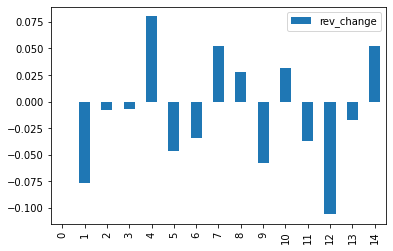

In [26]:
blaze_ca_gmv_change_data[['rev_change']].plot(kind = 'bar')

In [27]:
blaze_ca_gmv_change_data

,year_month,rev_pre_tax_post_discount,count_shop,lag_rev_pre_tax_post_discount,lag_count_shop,rev_per_shop,lag_rev_per_shop,rev_change
0,2021-08-31,59940637.30,195,NaN,NaN,307387.883590,NaN,NaN
1,2021-09-30,58766252.04,207,59940637.30,195.0,283894.937391,307387.883590,-0.076428
2,2021-10-31,63377982.71,225,58766252.04,207.0,281679.923156,283894.937391,-0.007802
3,2021-11-30,63792764.24,228,63377982.71,225.0,279792.825614,281679.923156,-0.006699
4,2021-12-31,72521153.59,240,63792764.24,228.0,302171.473292,279792.825614,0.079983
5,2022-01-31,70290344.08,244,72521153.59,240.0,288075.180656,302171.473292,-0.046650
6,2022-02-28,68129772.35,245,70290344.08,244.0,278080.703469,288075.180656,-0.034694
7,2022-03-31,73745755.49,252,68129772.35,245.0,292641.886865,278080.703469,0.052363
8,2022-04-30,74882286.50,249,73745755.49,252.0,300732.074297,292641.886865,0.027645
9,2022-05-31,71977419.98,254,74882286.50,249.0,283375.669213,300732.074297,-0.057714


In [28]:
rev_change_bm_with_weight = blaze_ca_gmv_change_data[['year_month','rev_change']]
rev_change_bm_with_weight['weight'] = [numpy.nan,numpy.nan,0.04,0.12,0.2,0.28,0.36,0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]
rev_change_bm_with_weight.columns = ['year_month','rev_change_bm','rev_change_weight']
rev_change_bm_with_weight = rev_change_bm_with_weight.reset_index(drop = True)
rev_change_bm_with_weight

,year_month,rev_change_bm,rev_change_weight
0,2021-08-31,NaN,NaN
1,2021-09-30,-0.076428,NaN
2,2021-10-31,-0.007802,0.04
3,2021-11-30,-0.006699,0.12
4,2021-12-31,0.079983,0.20
5,2022-01-31,-0.046650,0.28
6,2022-02-28,-0.034694,0.36
7,2022-03-31,0.052363,0.44
8,2022-04-30,0.027645,0.52
9,2022-05-31,-0.057714,0.60


In [29]:

blaze_gm_data_long_with_rev  = pd.merge(blaze_gm_data_long,rev_change_bm_with_weight,on=['year_month'], how='inner')
blaze_gm_data_long_with_rev['rev_change_var'] = blaze_gm_data_long_with_rev['rev_change'] - blaze_gm_data_long_with_rev['rev_change_bm']
blaze_gm_data_long_with_rev['rev_change_points'] = [gmv_change_variance_point_mapping(n) for n in blaze_gm_data_long_with_rev['rev_change_var']]
blaze_gm_data_long_with_rev['rev_change_total'] = blaze_gm_data_long_with_rev['rev_change_points'] * blaze_gm_data_long_with_rev['rev_change_weight']




In [30]:


blaze_gm_data_long_with_rev.tail()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total
3392,2022-10-31,5f99beff00fecc08ddc55c60,5f5a538f66916608cdc3f04e,118476.27,112692.11,62971.72,55504.55,0.468487,15,183114.28,0.488321,0.494328,0.492840,0.051327,0.052222,1.0,-0.000894,0.0,0.0
3393,2022-10-31,5fb468daca236e08cd6b0439,5f91f8de44e00808ce9520d2,577212.37,511841.61,310191.04,267021.33,0.462605,15,869083.14,0.461115,0.467620,0.460103,0.127717,0.052222,1.0,0.075495,10.0,10.0
3394,2022-10-31,61cb9310d6742c306cadc0f1,61cb9310d6742c306cadc0d8,67968.55,61202.26,26701.00,41267.55,0.607157,10,76180.80,0.606555,0.595157,0.539927,0.110556,0.052222,1.0,0.058335,10.0,10.0
3395,2022-10-31,5d65d142725a93082f22de8c,5d65d142725a93082f22de75,395415.67,366807.51,248532.45,146883.22,0.371465,15,697915.87,0.371041,0.370660,0.378696,0.077992,0.052222,1.0,0.025771,5.0,5.0
3396,2022-10-31,5d9ee0e86d8ce1082b9098de,5d9ee0e86d8ce1082b9098c6,579971.18,576306.66,244810.62,335160.56,0.577892,15,754031.31,0.574137,0.575555,0.602271,0.006359,0.052222,1.0,-0.045863,0.0,0.0


In [31]:

blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['shopid'] == '5c8844b3e0faca07c1ec05ec']

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total
8,2021-08-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,1391798.44,NaN,830472.07,561326.37,0.403310,15,830472.07,0.403310,0.403310,0.403310,NaN,NaN,NaN,NaN,NaN,NaN
190,2021-09-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,1074072.70,1391798.44,611701.37,462371.33,0.430484,15,1442173.44,0.416897,0.416897,0.416897,-0.228284,-0.076428,NaN,-0.151857,-5.0,NaN
385,2021-10-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,874744.85,1074072.70,496259.85,378485.00,0.432680,15,1938433.29,0.422158,0.422158,0.422158,-0.185581,-0.007802,0.04,-0.177779,-5.0,-0.2
589,2021-11-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,799791.11,874744.85,435482.17,364308.94,0.455505,15,1543443.39,0.439557,0.430495,0.430495,-0.085686,-0.006699,0.12,-0.078987,-2.5,-0.3
804,2021-12-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,815170.38,799791.11,423727.00,391443.38,0.480198,15,1355469.02,0.456128,0.440436,0.440436,0.019229,0.079983,0.20,-0.060754,-2.5,-0.5
1034,2022-01-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,737584.96,815170.38,385753.60,351831.36,0.477005,15,1244962.77,0.470903,0.446530,0.446530,-0.095177,-0.046650,0.28,-0.048527,0.0,0.0
1271,2022-02-28,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,657139.60,737584.96,382555.91,274583.69,0.417847,15,1192036.51,0.458350,0.448953,0.442433,-0.109066,-0.034694,0.36,-0.074372,-2.5,-0.9
1510,2022-03-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,637828.04,657139.60,350448.31,287379.73,0.450560,15,1118757.82,0.448470,0.452299,0.443449,-0.029387,0.052363,0.44,-0.081750,-2.5,-1.1
1755,2022-04-30,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,760663.72,637828.04,423784.99,336878.73,0.442875,15,1156789.21,0.437094,0.453998,0.443385,0.192584,0.027645,0.52,0.164939,10.0,5.2
2000,2022-05-31,5c8844b3e0faca07c1ec05ec,5c5e1cd8e0faca080f5db7fd,720346.24,760663.72,369500.65,350845.59,0.487051,15,1143733.95,0.460162,0.459256,0.447752,-0.053003,-0.057714,0.60,0.004711,5.0,3.0


# inventory

In [34]:
blaze_inv_data_all = pd.read_sql_query("""with base as (
    select *,
    DATE_DIFF(date,purchase_date,DAY) diff,
    current_quantity * unit_cost total_value
    from blaze_data.inventory
    where  lower(product_category) not like '%sample%'
    and lower(product_category) not like '%display%'
    and lower(product_category) not like '%promo%'
    and lower(product_category) not like '%test%'
    -- EXCLUDE SMALL COGS
    and unit_cost > 0.01
    and current_quantity > 0
    and current_quantity < 1000
    and date in ('2022-10-25','2022-10-18','2022-10-11','2022-10-04','2022-10-01')
    and state = 'CA'
),
base_by_group as (
select *,
case when diff < 180 then 'fresh'
     when diff >= 180 and diff < 270 then 'stale'
    else  'bad' end as inventory_group
from base
),
weekly_inv as (
    select date,
           shop_id          shopid,
           company_id       companyid,
           inventory_group,
           sum(total_value) inventory
    from base_by_group
    group by 1, 2, 3,4
)
select
shopid,
companyid,
inventory_group,
avg(inventory) inventory,
last_day('2022-10-31') year_month
from weekly_inv
group by 1,2,3""",engine)

In [35]:
blaze_inv_data_all['year_month'] = pd.to_datetime(blaze_inv_data_all['year_month'])

In [36]:
blaze_inv_data_all['shopid'].nunique()

388

In [37]:
blaze_inv_data_all

,shopid,companyid,inventory_group,inventory,year_month
0,57ea348c920f402b57dae66e,57ea348c920f402b57dae65b,stale,4036.5545,2022-10-31
1,5a513cb5819d9e686d0e9d5d,5a513cb5819d9e686d0e9d46,bad,16226.3568,2022-10-31
2,5aa6fbf2c182bb174aaf5f11,5aa6fbf2c182bb174aaf5efa,fresh,126298.0500,2022-10-31
3,5aa737d1819d9e548c66a26e,5aa737d1819d9e548c66a257,bad,16559.8920,2022-10-31
4,5b256a8eff7e6b08094adb42,5b1dbdf3cf43c1080b198e70,stale,23439.5180,2022-10-31
...,...,...,...,...,...
902,5e33733bdc09690856921d09,5e33733bdc09690856921cf1,bad,4300.8500,2022-10-31
903,5e33733bdc09690856921d09,5e33733bdc09690856921cf1,stale,7694.4100,2022-10-31
904,60a2e7b9b3d6203ac8fea106,60a2e7b9b3d6203ac8fea0ec,stale,4602.4300,2022-10-31
905,6140d950ea932b543eb12e75,6140d950ea932b543eb12e5c,stale,268.0000,2022-10-31


In [38]:
set(blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['year_month'] == '2022-10-31']['shopid']) - set(blaze_inv_data_all['shopid'])

set()

In [39]:
fresh_inv = blaze_inv_data_all[blaze_inv_data_all['inventory_group'] == 'fresh'][['year_month','shopid','companyid','inventory']]
stale_inv = blaze_inv_data_all[blaze_inv_data_all['inventory_group'] == 'stale'][['year_month','shopid','companyid','inventory']]

In [40]:
fresh_and_stale_inv = fresh_inv.merge(stale_inv, on = ['shopid','companyid','year_month'],how = 'outer')
fresh_and_stale_inv = fresh_and_stale_inv.fillna(0)

In [41]:
fresh_and_stale_inv.columns = ['year_month','shopid','companyid','inventory_fresh','inventory_stale']
fresh_and_stale_inv['inventory_fresh_and_stale'] = fresh_and_stale_inv['inventory_fresh']  + fresh_and_stale_inv['inventory_stale']

In [42]:
fresh_and_stale_inv

,year_month,shopid,companyid,inventory_fresh,inventory_stale,inventory_fresh_and_stale
0,2022-10-31,5aa6fbf2c182bb174aaf5f11,5aa6fbf2c182bb174aaf5efa,126298.050000,7276.694,133574.744000
1,2022-10-31,5b3e58f62ce2f50803995eaa,5b3e58f62ce2f50803995e94,148749.176000,2232.066,150981.242000
2,2022-10-31,5b6496ccebb2320839409957,5b6496ccebb2320839409941,300587.912000,128106.408,428694.320000
3,2022-10-31,5bd8a24a7979ec081454fac5,5bd8a24a7979ec081454faae,123410.666000,5992.342,129403.008000
4,2022-10-31,5c23dbf7db2bf108a5631e88,5c23dbf7db2bf108a5631e71,77810.071333,609.500,78419.571333
...,...,...,...,...,...,...
316,2022-10-31,5ba96aac00635e08245eb7c7,5ba96aac00635e08245eb7b0,0.000000,156.000,156.000000
317,2022-10-31,5cb742edbc1035080695c561,5c61b6be33463107fe9ceb85,0.000000,5000.000,5000.000000
318,2022-10-31,5c61b6be33463107fe9ceb9d,5c61b6be33463107fe9ceb85,0.000000,3000.000,3000.000000
319,2022-10-31,5eac4005e0faca07f879503a,5eac4005e0faca07f8795022,0.000000,1163.500,1163.500000


In [43]:
set(blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['year_month'] == '2022-10-31']['shopid']) - set(fresh_and_stale_inv['shopid'])



{'5bcad4618cc04c08353ffe15'}

# joined

In [44]:
data_joined = pd.merge(blaze_gm_data_long_with_rev,fresh_and_stale_inv,on=['year_month','shopid','companyid'], how='inner')



In [45]:
data_joined


,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale
0,2022-10-31,5b4e6bc58d96d7081b5b6d46,5b4e6bc58d96d7081b5b6d30,722549.56,713934.49,264762.67,457786.89,0.633572,15,785207.30,0.638984,0.647819,0.645511,0.012067,0.052222,1.0,-0.040154,0.0,0.0,482708.956333,68927.930667,551636.887000
1,2022-10-31,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,402534.19,391740.13,182543.98,219990.21,0.546513,15,554583.31,0.546343,0.550685,0.547438,0.027554,0.052222,1.0,-0.024667,0.0,0.0,216761.795000,23976.978000,240738.773000
2,2022-10-31,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1927187.77,1920320.99,910224.13,1016963.64,0.527693,13,2716141.28,0.535113,0.540238,0.529512,0.003576,0.052222,1.0,-0.048646,0.0,0.0,530891.209000,26055.058000,556946.267000
3,2022-10-31,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,884523.08,890571.49,424495.79,460027.29,0.520085,12,1281202.47,0.516411,0.516965,0.510535,-0.006792,0.052222,1.0,-0.059013,-2.5,-2.5,333731.301000,2476.368000,336207.669000
4,2022-10-31,5ea1db94e0faca07e12ca5f3,5e97c9bbc6641308cf7d31d9,267689.52,283330.10,129244.85,138444.67,0.517184,15,420086.77,0.504063,0.485160,0.511765,-0.055203,0.052222,1.0,-0.107424,-5.0,-5.0,124710.371000,11534.150000,136244.521000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2022-10-31,5f99beff00fecc08ddc55c60,5f5a538f66916608cdc3f04e,118476.27,112692.11,62971.72,55504.55,0.468487,15,183114.28,0.488321,0.494328,0.492840,0.051327,0.052222,1.0,-0.000894,0.0,0.0,104188.200000,27361.144000,131549.344000
212,2022-10-31,5fb468daca236e08cd6b0439,5f91f8de44e00808ce9520d2,577212.37,511841.61,310191.04,267021.33,0.462605,15,869083.14,0.461115,0.467620,0.460103,0.127717,0.052222,1.0,0.075495,10.0,10.0,290031.322000,18824.384000,308855.706000
213,2022-10-31,61cb9310d6742c306cadc0f1,61cb9310d6742c306cadc0d8,67968.55,61202.26,26701.00,41267.55,0.607157,10,76180.80,0.606555,0.595157,0.539927,0.110556,0.052222,1.0,0.058335,10.0,10.0,54569.864000,5830.304000,60400.168000
214,2022-10-31,5d65d142725a93082f22de8c,5d65d142725a93082f22de75,395415.67,366807.51,248532.45,146883.22,0.371465,15,697915.87,0.371041,0.370660,0.378696,0.077992,0.052222,1.0,0.025771,5.0,5.0,123451.202000,858.900000,124310.102000


In [46]:
data_joined['inventory_turnover'] = data_joined['sum_cogs_3m'] / data_joined['inventory_fresh_and_stale'] * 4
data_joined['year_month'] = pd.to_datetime(data_joined['year_month'])

In [47]:
data_joined[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2022-10-31,216


In [48]:
data_joined[data_joined['year_month'] >= '2021-10-31'].groupby(['year_month'])['inventory_turnover'].describe().reset_index()

,year_month,count,mean,std,min,25%,50%,75%,max
0,2022-10-31,216.0,10.752873,6.314575,0.0696,6.47824,9.723368,13.637297,36.489353


In [49]:
round(data_joined['inventory_turnover'].quantile(0.95),2)

22.56

# Vendor Churn

In [50]:
blaze_vc_data = pd.read_sql_query("""
-- purcase order data
with date as (
    SELECT last_day(year_month) year_month_all
FROM UNNEST(
    GENERATE_DATE_ARRAY(DATE('2021-08-01'), CURRENT_DATE(), INTERVAL 1 month)
) AS year_month
),
vendor as (
    select distinct vendor_id from blaze_data.purchase_orders
),
shop as (
    select distinct shop_id from blaze_data.purchase_orders
    where state = 'CA'
    and purchase_order_status = 'Closed'
    /*
    and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
                         */
),
all_data as (
    with sub as (
        select *
        from date
                 cross join vendor
    )
    select * from sub cross join shop
),
po_clean as (select * 
from  (
select DATE_DIFF(week_end, week_start, DAY) diff,* from blaze_data.purchase_orders
             WHERE not (week_start = '2022-01-29' and week_end = '2022-02-05')
and not (week_start = '2022-02-26' and week_end = '2022-03-05')
and not (week_start = '2022-03-27' and week_end = '2022-04-03'))
     where diff < 10)
     ,
po_data as (
    select last_day(week_start) year_month,
           shop_id,
           vendor_id,
           sum(total_cost)      total_amount

    from po_clean
    group by 1, 2, 3
),

vc_data as (
    select all_data.year_month_all,
           all_data.vendor_id,
           all_data.shop_id,
           COALESCE(po_data.total_amount, 0) amount,
           sum(po_data.total_amount) over (partition by all_data.shop_id,all_data.vendor_id) facility_total,
           sum(po_data.total_amount) over (partition by all_data.shop_id) all_vendor_total,
           sum(po_data.total_amount) over (partition by all_data.shop_id,all_data.vendor_id order by all_data.year_month_all rows between 3 preceding and current row) last_4m_total
           --lag( COALESCE(po_data.total_amount,0)) over (partition by all_data.vendor_id,all_data.shop_id order by year_month_all) lag_total_amount,

    from all_data
             left join po_data
                       on all_data.year_month_all = po_data.year_month
                           and all_data.vendor_id = po_data.vendor_id
                           and all_data.shop_id = po_data.shop_id
),

vc_data_weight as (
    select year_month_all,
           vendor_id,
           shop_id,
           amount,
           COALESCE(facility_total, 0)  vendor_total,
           COALESCE(all_vendor_total, 0) all_vendor_total,
           COALESCE(last_4m_total, 0) last_4m_total
    from vc_data
),
vc_data_weight_clean as (
    select
    year_month_all,
    vendor_id,
    shop_id,
    amount,
    vendor_total,
    all_vendor_total,
    last_4m_total,
    vendor_total / NULLIF(all_vendor_total, 0)  vendor_perc,
    case when last_4m_total = 0 then '4m_inactive' else '4m_active' end as activity,
    case
    when  vendor_total/ NULLIF(all_vendor_total, 0) > 0.001 then 'significant'
    else 'non-significant' end as significance
    from vc_data_weight
),
/* for debug
     select * from vc_data_weight_clean
                where shop_id = '5f0d3e91aa5bca08d2438446'
                and significance = 'significant'

 */

vc_final as (
    select
    *,
    case when activity = '4m_active' and significance = 'significant' then 'active'
    else (case when significance = 'significant' then 'inactive' else 'exclude' end) end as measure
    from vc_data_weight_clean
    )


select
shop_id shopid,
sum(vendor_perc) total_vc
from vc_final
where year_month_all = '2022-10-31'
and measure = 'inactive'
group by 1

""",engine)

In [51]:
blaze_vc_data

,shopid,total_vc
0,5f11d56c076bdb08d66a6e8a,0.165066
1,604910b57a8f9808d06fc758,0.115204
2,5aa6fbf2c182bb174aaf5f11,0.318166
3,619567c9848f790940332338,0.999265
4,60f84b4964f1c0641efa6b41,0.160837
...,...,...
239,5e7b7fb91a3bbe09119b2fff,0.133915
240,5fc5a9d0eaac0c08de3cbf5a,0.081950
241,60a2d2a51775b12de7610240,0.277942
242,6000fe33807ba708d56041fd,1.000000


In [52]:
data_joined_with_vc = data_joined.merge(blaze_vc_data,on = 'shopid',how = 'left')

In [53]:
data_joined_with_vc['total_vc'].describe()

count    191.000000
mean       0.287098
std        0.257747
min        0.005939
25%        0.128038
50%        0.190698
75%        0.315684
max        1.000000
Name: total_vc, dtype: float64

In [54]:
data_joined_with_vc = data_joined_with_vc.fillna(0)

In [55]:
data_joined_with_vc[data_joined_with_vc['total_vc'] == 0].shape

(25, 24)

# UW

In [56]:
recent = data_joined_with_vc[data_joined_with_vc['year_month'] == '2022-10-31']
recent = recent.reset_index(drop = True)

In [57]:
data_joined_with_vc

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc
0,2022-10-31,5b4e6bc58d96d7081b5b6d46,5b4e6bc58d96d7081b5b6d30,722549.56,713934.49,264762.67,457786.89,0.633572,15,785207.30,0.638984,0.647819,0.645511,0.012067,0.052222,1.0,-0.040154,0.0,0.0,482708.956333,68927.930667,551636.887000,5.693653,0.999464
1,2022-10-31,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,402534.19,391740.13,182543.98,219990.21,0.546513,15,554583.31,0.546343,0.550685,0.547438,0.027554,0.052222,1.0,-0.024667,0.0,0.0,216761.795000,23976.978000,240738.773000,9.214690,0.684409
2,2022-10-31,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1927187.77,1920320.99,910224.13,1016963.64,0.527693,13,2716141.28,0.535113,0.540238,0.529512,0.003576,0.052222,1.0,-0.048646,0.0,0.0,530891.209000,26055.058000,556946.267000,19.507385,0.161816
3,2022-10-31,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,884523.08,890571.49,424495.79,460027.29,0.520085,12,1281202.47,0.516411,0.516965,0.510535,-0.006792,0.052222,1.0,-0.059013,-2.5,-2.5,333731.301000,2476.368000,336207.669000,15.242989,0.071711
4,2022-10-31,5ea1db94e0faca07e12ca5f3,5e97c9bbc6641308cf7d31d9,267689.52,283330.10,129244.85,138444.67,0.517184,15,420086.77,0.504063,0.485160,0.511765,-0.055203,0.052222,1.0,-0.107424,-5.0,-5.0,124710.371000,11534.150000,136244.521000,12.333319,0.531214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2022-10-31,5f99beff00fecc08ddc55c60,5f5a538f66916608cdc3f04e,118476.27,112692.11,62971.72,55504.55,0.468487,15,183114.28,0.488321,0.494328,0.492840,0.051327,0.052222,1.0,-0.000894,0.0,0.0,104188.200000,27361.144000,131549.344000,5.567927,1.000000
212,2022-10-31,5fb468daca236e08cd6b0439,5f91f8de44e00808ce9520d2,577212.37,511841.61,310191.04,267021.33,0.462605,15,869083.14,0.461115,0.467620,0.460103,0.127717,0.052222,1.0,0.075495,10.0,10.0,290031.322000,18824.384000,308855.706000,11.255523,0.129231
213,2022-10-31,61cb9310d6742c306cadc0f1,61cb9310d6742c306cadc0d8,67968.55,61202.26,26701.00,41267.55,0.607157,10,76180.80,0.606555,0.595157,0.539927,0.110556,0.052222,1.0,0.058335,10.0,10.0,54569.864000,5830.304000,60400.168000,5.045072,0.000000
214,2022-10-31,5d65d142725a93082f22de8c,5d65d142725a93082f22de75,395415.67,366807.51,248532.45,146883.22,0.371465,15,697915.87,0.371041,0.370660,0.378696,0.077992,0.052222,1.0,0.025771,5.0,5.0,123451.202000,858.900000,124310.102000,22.457254,0.225691


In [58]:
recent[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2022-10-31,216


## gm % score

In [59]:
def get_gm_perc_scores(threshold,gm_3,gm_6,gm_all):
    # 3m score
    if gm_3 <= threshold[0][0]:
        score_3m = -2
    elif threshold[0][0] < gm_3 <= threshold[0][1]:
        score_3m = 0
    elif threshold[0][1] < gm_3 <= threshold[0][2]:
        score_3m = 5
    elif threshold[0][2] < gm_3 <= threshold[0][3]:
        score_3m = 5
    else:
        score_3m = 0
    # 6m score
    if gm_6 <= threshold[1][0]:
        score_6m = -2
    elif threshold[1][0] < gm_6 <= threshold[1][1]:
        score_6m = 0
    elif threshold[1][1] < gm_6 <= threshold[1][2]:
        score_6m = 5
    elif threshold[1][2] < gm_6 <= threshold[1][3]:
        score_6m = 5
    else:
        score_6m = 0
    # all time score
    if gm_all <= threshold[2][0]:
        score_all = -2
    elif threshold[2][0] < gm_all <= threshold[2][1]:
        score_all = 0
    elif threshold[2][1] < gm_all <= threshold[2][2]:
        score_all = 5
    elif threshold[2][2] < gm_all <= threshold[2][3]:
        score_all = 5
    else:
        score_all = 0
    return score_3m,score_6m,score_all
    

In [ ]:
#gm_threshold = [[0.47,0.53,0.59,0.7],[0.47,0.53,0.59,0.7],[0.47,0.53,0.59,0.7]]

In [ ]:
#gm_threshold = [[0.46,0.52,0.58,0.7],[0.46,0.52,0.58,0.7],[0.46,0.52,0.58,0.7]]

In [ ]:
#gm_threshold = [[0.45,0.51,0.57,0.7],[0.45,0.51,0.57,0.7],[0.45,0.51,0.57,0.7]]

In [60]:
gm_threshold = [[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7]]

In [61]:
gm_score_data = recent.apply(lambda row: get_gm_perc_scores(gm_threshold,row['avg_margin_3m'],row['avg_margin_6m'],row['avg_margin_all']),axis = 1)
recent_with_gm = pd.concat([recent, pd.DataFrame([list(y) for y in gm_score_data.values], columns = ['gm_3m_score', 'gm_6m_score','gm_all_score'])],axis=1)



## inventory turnover score

In [62]:
recent_with_gm['turnover_score'] = [10 if (recent_with_gm['inventory_turnover'][i] >= 6 and recent_with_gm['inventory_turnover'][i] <= 26) else 0 for i in range(len(recent_with_gm))]



In [63]:
recent_with_gm.head()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score
0,2022-10-31,5b4e6bc58d96d7081b5b6d46,5b4e6bc58d96d7081b5b6d30,722549.56,713934.49,264762.67,457786.89,0.633572,15,785207.30,0.638984,0.647819,0.645511,0.012067,0.052222,1.0,-0.040154,0.0,0.0,482708.956333,68927.930667,551636.887,5.693653,0.999464,5,5,5,0
1,2022-10-31,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,402534.19,391740.13,182543.98,219990.21,0.546513,15,554583.31,0.546343,0.550685,0.547438,0.027554,0.052222,1.0,-0.024667,0.0,0.0,216761.795000,23976.978000,240738.773,9.214690,0.684409,5,5,5,10
2,2022-10-31,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1927187.77,1920320.99,910224.13,1016963.64,0.527693,13,2716141.28,0.535113,0.540238,0.529512,0.003576,0.052222,1.0,-0.048646,0.0,0.0,530891.209000,26055.058000,556946.267,19.507385,0.161816,5,5,5,10
3,2022-10-31,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,884523.08,890571.49,424495.79,460027.29,0.520085,12,1281202.47,0.516411,0.516965,0.510535,-0.006792,0.052222,1.0,-0.059013,-2.5,-2.5,333731.301000,2476.368000,336207.669,15.242989,0.071711,5,5,5,10
4,2022-10-31,5ea1db94e0faca07e12ca5f3,5e97c9bbc6641308cf7d31d9,267689.52,283330.10,129244.85,138444.67,0.517184,15,420086.77,0.504063,0.485160,0.511765,-0.055203,0.052222,1.0,-0.107424,-5.0,-5.0,124710.371000,11534.150000,136244.521,12.333319,0.531214,5,0,5,10


## rev change score

In [64]:
rev_change_score = blaze_gm_data_long_with_rev[['shopid','rev_change_total']].groupby('shopid').sum().reset_index()

In [65]:
rev_change_score['rev_change_score'] = [max(min(round(rev_change_score['rev_change_total'][i],2),10),-10) for i in range(len(rev_change_score))]
rev_change_score.sort_values(by = 'rev_change_total')


,shopid,rev_change_total,rev_change_score
102,5ee44039b17a7208cb722279,-25.5,-10.0
179,60d376c7638c221fab13422c,-24.2,-10.0
15,5ba96aac00635e08245eb7c7,-18.4,-10.0
72,5e1cc22ca3b04d084c46b543,-18.3,-10.0
27,5c58fe549128cb07f824d3db,-17.6,-10.0
...,...,...,...
201,611df4df750db64ca4f656b5,42.6,10.0
174,60be6bd0becd5f0b0113c46b,45.3,10.0
234,619eabacbba49219e2bb84f4,48.7,10.0
170,60ac3fcb171b642773b5bba9,50.0,10.0


## gm $ score

In [66]:
gm_dollar_score = blaze_gm_data_long_with_rev[['shopid','profit_pre_tax_post_discount']].groupby('shopid').mean().reset_index()

In [67]:
gm_dollar_score['gm_dollar_score'] = [15 if gm_dollar_score['profit_pre_tax_post_discount'][i] >= 200000 else 0 for i in range(len(rev_change_score))]



In [68]:
recent_with_gm_and_rev_change = pd.merge(recent_with_gm,rev_change_score[['shopid','rev_change_score']],on=['shopid'], how='inner')
recent_with_gm_and_rev_change

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score
0,2022-10-31,5b4e6bc58d96d7081b5b6d46,5b4e6bc58d96d7081b5b6d30,722549.56,713934.49,264762.67,457786.89,0.633572,15,785207.30,0.638984,0.647819,0.645511,0.012067,0.052222,1.0,-0.040154,0.0,0.0,482708.956333,68927.930667,551636.887000,5.693653,0.999464,5,5,5,0,10.0
1,2022-10-31,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,402534.19,391740.13,182543.98,219990.21,0.546513,15,554583.31,0.546343,0.550685,0.547438,0.027554,0.052222,1.0,-0.024667,0.0,0.0,216761.795000,23976.978000,240738.773000,9.214690,0.684409,5,5,5,10,10.0
2,2022-10-31,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1927187.77,1920320.99,910224.13,1016963.64,0.527693,13,2716141.28,0.535113,0.540238,0.529512,0.003576,0.052222,1.0,-0.048646,0.0,0.0,530891.209000,26055.058000,556946.267000,19.507385,0.161816,5,5,5,10,10.0
3,2022-10-31,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,884523.08,890571.49,424495.79,460027.29,0.520085,12,1281202.47,0.516411,0.516965,0.510535,-0.006792,0.052222,1.0,-0.059013,-2.5,-2.5,333731.301000,2476.368000,336207.669000,15.242989,0.071711,5,5,5,10,10.0
4,2022-10-31,5ea1db94e0faca07e12ca5f3,5e97c9bbc6641308cf7d31d9,267689.52,283330.10,129244.85,138444.67,0.517184,15,420086.77,0.504063,0.485160,0.511765,-0.055203,0.052222,1.0,-0.107424,-5.0,-5.0,124710.371000,11534.150000,136244.521000,12.333319,0.531214,5,0,5,10,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2022-10-31,5f99beff00fecc08ddc55c60,5f5a538f66916608cdc3f04e,118476.27,112692.11,62971.72,55504.55,0.468487,15,183114.28,0.488321,0.494328,0.492840,0.051327,0.052222,1.0,-0.000894,0.0,0.0,104188.200000,27361.144000,131549.344000,5.567927,1.000000,0,0,0,0,10.0
212,2022-10-31,5fb468daca236e08cd6b0439,5f91f8de44e00808ce9520d2,577212.37,511841.61,310191.04,267021.33,0.462605,15,869083.14,0.461115,0.467620,0.460103,0.127717,0.052222,1.0,0.075495,10.0,10.0,290031.322000,18824.384000,308855.706000,11.255523,0.129231,0,0,0,10,10.0
213,2022-10-31,61cb9310d6742c306cadc0f1,61cb9310d6742c306cadc0d8,67968.55,61202.26,26701.00,41267.55,0.607157,10,76180.80,0.606555,0.595157,0.539927,0.110556,0.052222,1.0,0.058335,10.0,10.0,54569.864000,5830.304000,60400.168000,5.045072,0.000000,5,5,5,0,10.0
214,2022-10-31,5d65d142725a93082f22de8c,5d65d142725a93082f22de75,395415.67,366807.51,248532.45,146883.22,0.371465,15,697915.87,0.371041,0.370660,0.378696,0.077992,0.052222,1.0,0.025771,5.0,5.0,123451.202000,858.900000,124310.102000,22.457254,0.225691,-2,-2,-2,10,10.0


# VC score

In [69]:
recent_with_gm_and_rev_change['vc_score'] = [10 if recent_with_gm_and_rev_change['total_vc'][i] < 0.17 else 0 for i in range(len(recent_with_gm_and_rev_change))]



# Final

In [70]:
final = pd.merge(recent_with_gm_and_rev_change,gm_dollar_score[['shopid','gm_dollar_score']],on=['shopid'], how='inner')



In [71]:
final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score'] + final['vc_score']
final['credit_limit_raw'] = [round(min(final['sum_cogs_3m'][i],final['inventory_fresh'][i]),0) for i in range(len(final))]
final['potential_credit_limit'] = round(final['credit_limit_raw'],-4) 
final['initial_credit_limit'] = final['potential_credit_limit'] / 2 


In [72]:
final

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
0,2022-10-31,5b4e6bc58d96d7081b5b6d46,5b4e6bc58d96d7081b5b6d30,722549.56,713934.49,264762.67,457786.89,0.633572,15,785207.30,0.638984,0.647819,0.645511,0.012067,0.052222,1.0,-0.040154,0.0,0.0,482708.956333,68927.930667,551636.887000,5.693653,0.999464,5,5,5,0,10.0,0,15,15,15,25.0,482709.0,480000.0,240000.0
1,2022-10-31,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,402534.19,391740.13,182543.98,219990.21,0.546513,15,554583.31,0.546343,0.550685,0.547438,0.027554,0.052222,1.0,-0.024667,0.0,0.0,216761.795000,23976.978000,240738.773000,9.214690,0.684409,5,5,5,10,10.0,0,15,15,15,35.0,216762.0,220000.0,110000.0
2,2022-10-31,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1927187.77,1920320.99,910224.13,1016963.64,0.527693,13,2716141.28,0.535113,0.540238,0.529512,0.003576,0.052222,1.0,-0.048646,0.0,0.0,530891.209000,26055.058000,556946.267000,19.507385,0.161816,5,5,5,10,10.0,10,15,15,15,45.0,530891.0,530000.0,265000.0
3,2022-10-31,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,884523.08,890571.49,424495.79,460027.29,0.520085,12,1281202.47,0.516411,0.516965,0.510535,-0.006792,0.052222,1.0,-0.059013,-2.5,-2.5,333731.301000,2476.368000,336207.669000,15.242989,0.071711,5,5,5,10,10.0,10,15,15,15,45.0,333731.0,330000.0,165000.0
4,2022-10-31,5ea1db94e0faca07e12ca5f3,5e97c9bbc6641308cf7d31d9,267689.52,283330.10,129244.85,138444.67,0.517184,15,420086.77,0.504063,0.485160,0.511765,-0.055203,0.052222,1.0,-0.107424,-5.0,-5.0,124710.371000,11534.150000,136244.521000,12.333319,0.531214,5,0,5,10,7.5,0,0,10,10,27.5,124710.0,120000.0,60000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2022-10-31,5f99beff00fecc08ddc55c60,5f5a538f66916608cdc3f04e,118476.27,112692.11,62971.72,55504.55,0.468487,15,183114.28,0.488321,0.494328,0.492840,0.051327,0.052222,1.0,-0.000894,0.0,0.0,104188.200000,27361.144000,131549.344000,5.567927,1.000000,0,0,0,0,10.0,0,0,0,0,10.0,104188.0,100000.0,50000.0
212,2022-10-31,5fb468daca236e08cd6b0439,5f91f8de44e00808ce9520d2,577212.37,511841.61,310191.04,267021.33,0.462605,15,869083.14,0.461115,0.467620,0.460103,0.127717,0.052222,1.0,0.075495,10.0,10.0,290031.322000,18824.384000,308855.706000,11.255523,0.129231,0,0,0,10,10.0,10,15,0,15,45.0,290031.0,290000.0,145000.0
213,2022-10-31,61cb9310d6742c306cadc0f1,61cb9310d6742c306cadc0d8,67968.55,61202.26,26701.00,41267.55,0.607157,10,76180.80,0.606555,0.595157,0.539927,0.110556,0.052222,1.0,0.058335,10.0,10.0,54569.864000,5830.304000,60400.168000,5.045072,0.000000,5,5,5,0,10.0,10,0,15,15,35.0,54570.0,50000.0,25000.0
214,2022-10-31,5d65d142725a93082f22de8c,5d65d142725a93082f22de75,395415.67,366807.51,248532.45,146883.22,0.371465,15,697915.87,0.371041,0.370660,0.378696,0.077992,0.052222,1.0,0.025771,5.0,5.0,123451.202000,858.900000,124310.102000,22.457254,0.225691,-2,-2,-2,10,10.0,0,0,-6,-6,14.0,123451.0,120000.0,60000.0


In [ ]:
# final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
# final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
# final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score'] 
# final['credit_limit'] = [round(min(final['sum_cogs_3m'][i],final['inventory'][i]),0) for i in range(len(final))]
                        



In [73]:

final['total_score'].describe()

count    216.00000
mean      30.51250
std       12.82594
min      -16.00000
25%       24.37500
50%       35.00000
75%       40.00000
max       45.00000
Name: total_score, dtype: float64

In [74]:
final['shopid'].nunique()

216

In [75]:
#final.to_csv('blaze_ca_july_all.csv')

In [76]:
pass_list = final[final['total_score'] >= 30]

In [77]:
pass_list

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
1,2022-10-31,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,402534.19,391740.13,182543.98,219990.21,0.546513,15,554583.31,0.546343,0.550685,0.547438,0.027554,0.052222,1.0,-0.024667,0.0,0.0,216761.7950,23976.978000,240738.773000,9.214690,0.684409,5,5,5,10,10.0,0,15,15,15,35.0,216762.0,220000.0,110000.0
2,2022-10-31,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1927187.77,1920320.99,910224.13,1016963.64,0.527693,13,2716141.28,0.535113,0.540238,0.529512,0.003576,0.052222,1.0,-0.048646,0.0,0.0,530891.2090,26055.058000,556946.267000,19.507385,0.161816,5,5,5,10,10.0,10,15,15,15,45.0,530891.0,530000.0,265000.0
3,2022-10-31,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,884523.08,890571.49,424495.79,460027.29,0.520085,12,1281202.47,0.516411,0.516965,0.510535,-0.006792,0.052222,1.0,-0.059013,-2.5,-2.5,333731.3010,2476.368000,336207.669000,15.242989,0.071711,5,5,5,10,10.0,10,15,15,15,45.0,333731.0,330000.0,165000.0
5,2022-10-31,5ee3fa266c853308d5d888f7,5ee3fa266c853308d5d888df,654800.25,700430.70,456730.77,198069.48,0.302488,15,1472448.12,0.318858,0.336250,0.307341,-0.065146,0.052222,1.0,-0.117368,-5.0,-5.0,491092.3990,24177.840000,515270.239000,11.430492,0.000000,-2,-2,-2,10,2.7,10,15,-6,9,31.7,491092.0,490000.0,245000.0
7,2022-10-31,619ea9d175d1c25e4e391e96,619ea9d075d1c25e4e391e7d,625272.36,609869.09,272521.17,352751.19,0.564156,10,803263.20,0.561536,0.556930,0.546794,0.025257,0.052222,1.0,-0.026965,0.0,0.0,133597.5530,4752.142000,138349.695000,23.224141,0.101734,5,5,5,10,10.0,10,15,15,15,45.0,133598.0,130000.0,65000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2022-10-31,5d5cbf574ee905081fdcc611,5d5cbf574ee905081fdcc5fa,547923.17,547804.24,290653.43,257269.74,0.469536,15,881136.10,0.466673,0.479276,0.467965,0.000217,0.052222,1.0,-0.052004,-2.5,-2.5,317172.2255,24645.349000,341817.574500,10.311185,0.250585,0,0,0,10,10.0,0,15,0,15,35.0,317172.0,320000.0,160000.0
210,2022-10-31,5f3bff8f5411ec08d9bc6810,5bd8a24a7979ec081454faae,752947.39,763936.71,297014.23,455933.16,0.605531,15,986910.84,0.564493,0.517488,0.482015,-0.014385,0.052222,1.0,-0.066607,-2.5,-2.5,217385.2920,1645.716000,219031.008000,18.023217,0.117837,5,5,0,10,10.0,10,15,10,15,45.0,217385.0,220000.0,110000.0
212,2022-10-31,5fb468daca236e08cd6b0439,5f91f8de44e00808ce9520d2,577212.37,511841.61,310191.04,267021.33,0.462605,15,869083.14,0.461115,0.467620,0.460103,0.127717,0.052222,1.0,0.075495,10.0,10.0,290031.3220,18824.384000,308855.706000,11.255523,0.129231,0,0,0,10,10.0,10,15,0,15,45.0,290031.0,290000.0,145000.0
213,2022-10-31,61cb9310d6742c306cadc0f1,61cb9310d6742c306cadc0d8,67968.55,61202.26,26701.00,41267.55,0.607157,10,76180.80,0.606555,0.595157,0.539927,0.110556,0.052222,1.0,0.058335,10.0,10.0,54569.8640,5830.304000,60400.168000,5.045072,0.000000,5,5,5,0,10.0,10,0,15,15,35.0,54570.0,50000.0,25000.0


In [78]:
final_pass = pass_list[(pass_list['profit_pre_tax_post_discount'] >= 25000) & (pass_list['potential_credit_limit'] >= 30000)]
final_pass = final_pass.reset_index(drop = True)

In [ ]:
#final_pass['credit_limit_final'] = [min(max(final_pass['credit_limit'][i],50000),250000) for i in range(len(final_pass))]

In [79]:
def calculate_interest_rate(score, full_score):
    score_ratio = score / full_score
    placeholder = (1 + 0.5 * (1 - score_ratio)) * 0.015
    rate = placeholder * 12
    return round(placeholder, 4), round(rate, 4)

In [80]:
final_pass['annual_rate'] = [calculate_interest_rate(final_pass['total_score'][i],45)[1] for i in range(len(final_pass))]
final_pass['monthly_rate'] = [calculate_interest_rate(final_pass['total_score'][i],45)[0] for i in range(len(final_pass))]



In [81]:
final_pass.shape[0] / final.shape[0]

0.5694444444444444

In [82]:
final_pass.shape[0]

123

In [83]:
final_pass

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit,annual_rate,monthly_rate
0,2022-10-31,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,402534.19,391740.13,182543.98,219990.21,0.546513,15,554583.31,0.546343,0.550685,0.547438,0.027554,0.052222,1.0,-0.024667,0.0,0.0,216761.7950,23976.978000,240738.773000,9.214690,0.684409,5,5,5,10,10.0,0,15,15,15,35.0,216762.0,220000.0,110000.0,0.2000,0.0167
1,2022-10-31,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1927187.77,1920320.99,910224.13,1016963.64,0.527693,13,2716141.28,0.535113,0.540238,0.529512,0.003576,0.052222,1.0,-0.048646,0.0,0.0,530891.2090,26055.058000,556946.267000,19.507385,0.161816,5,5,5,10,10.0,10,15,15,15,45.0,530891.0,530000.0,265000.0,0.1800,0.0150
2,2022-10-31,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,884523.08,890571.49,424495.79,460027.29,0.520085,12,1281202.47,0.516411,0.516965,0.510535,-0.006792,0.052222,1.0,-0.059013,-2.5,-2.5,333731.3010,2476.368000,336207.669000,15.242989,0.071711,5,5,5,10,10.0,10,15,15,15,45.0,333731.0,330000.0,165000.0,0.1800,0.0150
3,2022-10-31,5ee3fa266c853308d5d888f7,5ee3fa266c853308d5d888df,654800.25,700430.70,456730.77,198069.48,0.302488,15,1472448.12,0.318858,0.336250,0.307341,-0.065146,0.052222,1.0,-0.117368,-5.0,-5.0,491092.3990,24177.840000,515270.239000,11.430492,0.000000,-2,-2,-2,10,2.7,10,15,-6,9,31.7,491092.0,490000.0,245000.0,0.2066,0.0172
4,2022-10-31,619ea9d175d1c25e4e391e96,619ea9d075d1c25e4e391e7d,625272.36,609869.09,272521.17,352751.19,0.564156,10,803263.20,0.561536,0.556930,0.546794,0.025257,0.052222,1.0,-0.026965,0.0,0.0,133597.5530,4752.142000,138349.695000,23.224141,0.101734,5,5,5,10,10.0,10,15,15,15,45.0,133598.0,130000.0,65000.0,0.1800,0.0150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-10-31,5d5cbf574ee905081fdcc611,5d5cbf574ee905081fdcc5fa,547923.17,547804.24,290653.43,257269.74,0.469536,15,881136.10,0.466673,0.479276,0.467965,0.000217,0.052222,1.0,-0.052004,-2.5,-2.5,317172.2255,24645.349000,341817.574500,10.311185,0.250585,0,0,0,10,10.0,0,15,0,15,35.0,317172.0,320000.0,160000.0,0.2000,0.0167
119,2022-10-31,5f3bff8f5411ec08d9bc6810,5bd8a24a7979ec081454faae,752947.39,763936.71,297014.23,455933.16,0.605531,15,986910.84,0.564493,0.517488,0.482015,-0.014385,0.052222,1.0,-0.066607,-2.5,-2.5,217385.2920,1645.716000,219031.008000,18.023217,0.117837,5,5,0,10,10.0,10,15,10,15,45.0,217385.0,220000.0,110000.0,0.1800,0.0150
120,2022-10-31,5fb468daca236e08cd6b0439,5f91f8de44e00808ce9520d2,577212.37,511841.61,310191.04,267021.33,0.462605,15,869083.14,0.461115,0.467620,0.460103,0.127717,0.052222,1.0,0.075495,10.0,10.0,290031.3220,18824.384000,308855.706000,11.255523,0.129231,0,0,0,10,10.0,10,15,0,15,45.0,290031.0,290000.0,145000.0,0.1800,0.0150
121,2022-10-31,61cb9310d6742c306cadc0f1,61cb9310d6742c306cadc0d8,67968.55,61202.26,26701.00,41267.55,0.607157,10,76180.80,0.606555,0.595157,0.539927,0.110556,0.052222,1.0,0.058335,10.0,10.0,54569.8640,5830.304000,60400.168000,5.045072,0.000000,5,5,5,0,10.0,10,0,15,15,35.0,54570.0,50000.0,25000.0,0.2000,0.0167


# output data

In [84]:
final_pass[['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
       'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
       'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
       'inventory_fresh_and_stale', 'inventory_turnover', 'total_vc', 'gm_3m_score',
       'gm_6m_score', 'gm_all_score', 'total_gm_perc_score', 'gm_dollar_score', 'total_gm_score', 'turnover_score', 'rev_change_score',
       'vc_score','total_score', 'credit_limit_raw', 'potential_credit_limit', 'initial_credit_limit','annual_rate',
       'monthly_rate']]

,shopid,companyid,rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,total_gm_perc_score,gm_dollar_score,total_gm_score,turnover_score,rev_change_score,vc_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit,annual_rate,monthly_rate
0,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,402534.19,182543.98,219990.21,0.546513,554583.31,0.546343,0.550685,0.547438,240738.773000,9.214690,0.684409,5,5,5,15,15,15,10,10.0,0,35.0,216762.0,220000.0,110000.0,0.2000,0.0167
1,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1927187.77,910224.13,1016963.64,0.527693,2716141.28,0.535113,0.540238,0.529512,556946.267000,19.507385,0.161816,5,5,5,15,15,15,10,10.0,10,45.0,530891.0,530000.0,265000.0,0.1800,0.0150
2,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,884523.08,424495.79,460027.29,0.520085,1281202.47,0.516411,0.516965,0.510535,336207.669000,15.242989,0.071711,5,5,5,15,15,15,10,10.0,10,45.0,333731.0,330000.0,165000.0,0.1800,0.0150
3,5ee3fa266c853308d5d888f7,5ee3fa266c853308d5d888df,654800.25,456730.77,198069.48,0.302488,1472448.12,0.318858,0.336250,0.307341,515270.239000,11.430492,0.000000,-2,-2,-2,-6,15,9,10,2.7,10,31.7,491092.0,490000.0,245000.0,0.2066,0.0172
4,619ea9d175d1c25e4e391e96,619ea9d075d1c25e4e391e7d,625272.36,272521.17,352751.19,0.564156,803263.20,0.561536,0.556930,0.546794,138349.695000,23.224141,0.101734,5,5,5,15,15,15,10,10.0,10,45.0,133598.0,130000.0,65000.0,0.1800,0.0150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,5d5cbf574ee905081fdcc611,5d5cbf574ee905081fdcc5fa,547923.17,290653.43,257269.74,0.469536,881136.10,0.466673,0.479276,0.467965,341817.574500,10.311185,0.250585,0,0,0,0,15,15,10,10.0,0,35.0,317172.0,320000.0,160000.0,0.2000,0.0167
119,5f3bff8f5411ec08d9bc6810,5bd8a24a7979ec081454faae,752947.39,297014.23,455933.16,0.605531,986910.84,0.564493,0.517488,0.482015,219031.008000,18.023217,0.117837,5,5,0,10,15,15,10,10.0,10,45.0,217385.0,220000.0,110000.0,0.1800,0.0150
120,5fb468daca236e08cd6b0439,5f91f8de44e00808ce9520d2,577212.37,310191.04,267021.33,0.462605,869083.14,0.461115,0.467620,0.460103,308855.706000,11.255523,0.129231,0,0,0,0,15,15,10,10.0,10,45.0,290031.0,290000.0,145000.0,0.1800,0.0150
121,61cb9310d6742c306cadc0f1,61cb9310d6742c306cadc0d8,67968.55,26701.00,41267.55,0.607157,76180.80,0.606555,0.595157,0.539927,60400.168000,5.045072,0.000000,5,5,5,15,0,15,0,10.0,10,35.0,54570.0,50000.0,25000.0,0.2000,0.0167


In [85]:
final_pass[['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
       'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
       'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
       'inventory_fresh_and_stale', 'inventory_turnover', 'total_vc', 'gm_3m_score',
       'gm_6m_score', 'gm_all_score', 'total_gm_perc_score', 'gm_dollar_score', 'total_gm_score', 'turnover_score', 'rev_change_score',
       'vc_score','total_score', 'credit_limit_raw', 'potential_credit_limit', 'initial_credit_limit', 'annual_rate',
       'monthly_rate']].to_csv('blaze_ca_nov_approval.csv')

In [86]:
final[['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
       'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
       'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
       'inventory_fresh_and_stale', 'inventory_turnover', 'total_vc', 'gm_3m_score',
       'gm_6m_score', 'gm_all_score', 'total_gm_perc_score', 'gm_dollar_score', 'total_gm_score', 'turnover_score', 'rev_change_score',
       'vc_score','total_score']]

,shopid,companyid,rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,total_gm_perc_score,gm_dollar_score,total_gm_score,turnover_score,rev_change_score,vc_score,total_score
0,5b4e6bc58d96d7081b5b6d46,5b4e6bc58d96d7081b5b6d30,722549.56,264762.67,457786.89,0.633572,785207.30,0.638984,0.647819,0.645511,551636.887000,5.693653,0.999464,5,5,5,15,15,15,0,10.0,0,25.0
1,5d269b0a75941307f4f7823a,5d269b0a75941307f4f78223,402534.19,182543.98,219990.21,0.546513,554583.31,0.546343,0.550685,0.547438,240738.773000,9.214690,0.684409,5,5,5,15,15,15,10,10.0,0,35.0
2,616a37dcd771ce141b7d4068,60edb16f8d68a874d1592862,1927187.77,910224.13,1016963.64,0.527693,2716141.28,0.535113,0.540238,0.529512,556946.267000,19.507385,0.161816,5,5,5,15,15,15,10,10.0,10,45.0
3,616df4f2eb1a5f088b5fe9b9,616df4f2eb1a5f088b5fe9a0,884523.08,424495.79,460027.29,0.520085,1281202.47,0.516411,0.516965,0.510535,336207.669000,15.242989,0.071711,5,5,5,15,15,15,10,10.0,10,45.0
4,5ea1db94e0faca07e12ca5f3,5e97c9bbc6641308cf7d31d9,267689.52,129244.85,138444.67,0.517184,420086.77,0.504063,0.485160,0.511765,136244.521000,12.333319,0.531214,5,0,5,10,0,10,10,7.5,0,27.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,5f99beff00fecc08ddc55c60,5f5a538f66916608cdc3f04e,118476.27,62971.72,55504.55,0.468487,183114.28,0.488321,0.494328,0.492840,131549.344000,5.567927,1.000000,0,0,0,0,0,0,0,10.0,0,10.0
212,5fb468daca236e08cd6b0439,5f91f8de44e00808ce9520d2,577212.37,310191.04,267021.33,0.462605,869083.14,0.461115,0.467620,0.460103,308855.706000,11.255523,0.129231,0,0,0,0,15,15,10,10.0,10,45.0
213,61cb9310d6742c306cadc0f1,61cb9310d6742c306cadc0d8,67968.55,26701.00,41267.55,0.607157,76180.80,0.606555,0.595157,0.539927,60400.168000,5.045072,0.000000,5,5,5,15,0,15,0,10.0,10,35.0
214,5d65d142725a93082f22de8c,5d65d142725a93082f22de75,395415.67,248532.45,146883.22,0.371465,697915.87,0.371041,0.370660,0.378696,124310.102000,22.457254,0.225691,-2,-2,-2,-6,0,-6,10,10.0,0,14.0


In [87]:
final[['shopid', 'companyid', 'rev_pre_tax_post_discount', 'cogs',
       'profit_pre_tax_post_discount', 'margin_pre_tax_post_discount',
       'sum_cogs_3m', 'avg_margin_3m', 'avg_margin_6m', 'avg_margin_all',
       'inventory_fresh_and_stale', 'inventory_turnover', 'total_vc', 'gm_3m_score',
       'gm_6m_score', 'gm_all_score', 'total_gm_perc_score', 'gm_dollar_score', 'total_gm_score', 'turnover_score', 'rev_change_score',
       'vc_score','total_score']].to_csv('blaze_ca_nov_all.csv')

# analysis to compare with last month

In [101]:
prev_approve = pd.read_csv('blaze_ca_oct_approval.csv',index_col=0)
prev_all = pd.read_csv('blaze_ca_oct_all.csv',index_col=0)

In [102]:
# newly approved
newly_added_list = list(set(final_pass['shopid']) - set(prev_approve['shopid']))

In [103]:
newly_added_list

['60946716ebdf211020253ce1',
 '60da109eb322d56dcd668555',
 '5e2a1c1c1471bd0833a4358a',
 '5bd8a24a7979ec081454fac5',
 '5b92e4bd12fdf507f38638f4',
 '61d743b0b029ec09e920c31b',
 '5b3591eac2af87082e00e713']

In [104]:
final_pass[final_pass['shopid'].isin(newly_added_list)][['shopid','total_score']]

,shopid,total_score
7,5b92e4bd12fdf507f38638f4,30.0
11,5bd8a24a7979ec081454fac5,33.0
32,5b3591eac2af87082e00e713,35.0
49,60da109eb322d56dcd668555,35.0
79,5e2a1c1c1471bd0833a4358a,45.0
103,60946716ebdf211020253ce1,35.0
116,61d743b0b029ec09e920c31b,35.0


In [105]:
prev_all[prev_all['shopid'].isin(newly_added_list)][['shopid','total_score']]

,shopid,total_score
68,5b92e4bd12fdf507f38638f4,28.0
87,5e2a1c1c1471bd0833a4358a,45.0
95,60946716ebdf211020253ce1,35.0
132,5b3591eac2af87082e00e713,25.0
136,5bd8a24a7979ec081454fac5,26.0
157,60da109eb322d56dcd668555,25.0
194,61d743b0b029ec09e920c31b,25.0


In [99]:
# dropoffs
dropoff_lsit = list(set(prev['shopid']) - set(final_pass['shopid']))

In [110]:
final[final['shopid'].isin(dropoff_lsit)]

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
6,2022-10-31,5ff8e7ff70b74f08c83f44f2,5ff8e7ff70b74f08c83f44da,229556.22,251889.66,127886.27,101669.95,0.442898,15,408480.28,0.451011,0.458616,0.463618,-0.088664,0.052222,1.0,-0.140885,-5.0,-5.0,174968.514000,22349.329,197317.843000,8.280656,0.134991,0,0,0,10,9.5,10,0,0,0,29.5,174969.0,170000.0,85000.0
21,2022-10-31,6037e3abfc871108dc34f5ab,6037e3abfc871108dc34f592,271759.02,278358.07,131572.91,140186.11,0.515847,15,352986.46,0.574209,0.590304,0.590145,-0.023707,0.052222,1.0,-0.075929,-2.5,-2.5,282454.062667,420479.862,702933.924667,2.008647,0.212091,5,5,5,0,3.4,0,15,15,15,18.4,282454.0,280000.0,140000.0
39,2022-10-31,60be6bd0becd5f0b0113c46b,60be6bd0becd5f0b0113c452,273013.36,244499.78,93681.14,179332.22,0.656862,13,259389.84,0.654357,0.651181,0.644793,0.116620,0.052222,1.0,0.064399,10.0,10.0,365662.276000,144291.332,509953.608000,2.034615,0.184803,5,5,5,0,10.0,0,0,15,15,25.0,259390.0,260000.0,130000.0
95,2022-10-31,620ab3f30176a86e81b12358,5ee44039b17a7208cb722261,179926.22,188891.57,86986.50,92939.72,0.516544,9,267598.13,0.517642,0.491698,0.479492,-0.047463,0.052222,1.0,-0.099684,-2.5,-2.5,118599.743667,34856.482,153456.225667,6.975230,0.233228,5,0,0,10,10.0,0,0,5,5,25.0,118600.0,120000.0,60000.0
101,2022-10-31,608c1ea5600d0f74821dd3c3,608c1ea5600d0f74821dd3aa,279064.84,295182.50,91668.32,187396.52,0.671516,15,289683.20,0.663966,0.663928,0.660953,-0.054602,0.052222,1.0,-0.106824,-5.0,-5.0,180818.938000,15426.570,196245.508000,5.904506,0.252549,5,5,5,0,10.0,0,15,15,15,25.0,180819.0,180000.0,90000.0
142,2022-10-31,615b2b7629d6d61b3d2ec4ba,615b2b7629d6d61b3d2ec47b,297354.40,299739.07,79850.35,217504.05,0.731464,10,219010.45,0.755635,0.724386,0.701174,-0.007956,0.052222,1.0,-0.060177,-2.5,-2.5,100231.613000,2236.283,102467.896000,8.549427,0.205389,0,0,0,10,10.0,0,0,0,0,20.0,100232.0,100000.0,50000.0
151,2022-10-31,5a664f97819d9e5ec7c928c0,5a664f97819d9e5ec7c928a9,159553.36,173696.23,48836.15,110717.21,0.693920,15,153467.06,0.693464,0.695322,0.645539,-0.081423,0.052222,1.0,-0.133645,-5.0,-5.0,23057.010000,3796.600,26853.610000,22.859803,0.275295,5,5,5,10,10.0,0,0,15,15,35.0,23057.0,20000.0,10000.0
157,2022-10-31,621d088f747c212bad34afe0,621d088f747c212bad34afc6,95265.06,70352.34,46334.48,48930.58,0.513626,8,103233.90,0.526063,0.524014,0.504920,0.354114,0.052222,1.0,0.301892,10.0,10.0,62405.706000,11837.137,74242.843000,5.561958,0.270391,5,5,5,0,10.0,0,0,15,15,25.0,62406.0,60000.0,30000.0
184,2022-10-31,5ef6456350d91a08e6ea773b,5c9da826c669100839d27530,322597.92,322744.71,134106.64,188491.28,0.584292,15,407841.60,0.590856,0.590403,0.585698,-0.000455,0.052222,1.0,-0.052676,-2.5,-2.5,208526.387667,29059.100,237585.487667,6.866440,0.101130,5,5,5,10,-6.5,10,15,15,15,28.5,208526.0,210000.0,105000.0
187,2022-10-31,5c23dbf7db2bf108a5631e88,5c23dbf7db2bf108a5631e71,285180.41,263182.73,98715.71,186464.70,0.653848,15,268647.10,0.673399,0.758835,0.734189,0.083583,0.052222,1.0,0.031362,5.0,5.0,77810.071333,609.500,78419.571333,13.703064,1.000000,5,0,0,10,10.0,0,0,5,5,25.0,77810.0,80000.0,40000.0


# summary

In [130]:
print('Total number of shop to UW: ' + str(len(final))+ ' (have at least 6m of data)')
print('Total number of shops approved: ' + str(len(final_pass)))
print('The approval rate is: ' + str(round(len(final_pass)/len(final),2)))
print('Total Final Limit rounded: '+ str(sum(final_pass['potential_credit_limit'])))
print('Average Monthly Rate: ' + str(numpy.mean(final_pass['monthly_rate'])))

Total number of shop to UW: 216 (have at least 6m of data)
Total number of shops approved: 123
The approval rate is: 0.57
Total Final Limit rounded: 19890000.0
Average Monthly Rate: 0.016034959349593494


In [132]:
# customers we use blaze data to UW right now:
final[final['shopid'].isin(['5d40d66f4c431007fe6ab25c','618308a8039e9b65e2a624c2','5c72d6b549d85a07d2127646'])]



,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory_fresh,inventory_stale,inventory_fresh_and_stale,inventory_turnover,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score,rev_change_score,vc_score,gm_dollar_score,total_gm_perc_score,total_gm_score,total_score,credit_limit_raw,potential_credit_limit,initial_credit_limit
94,2022-10-31,618308a8039e9b65e2a624c2,5d40d66f4c431007fe6ab245,239467.66,242100.09,96855.54,142612.12,0.595538,11,302501.08,0.578116,0.579656,0.584898,-0.010873,0.052222,1.0,-0.063095,-2.5,-2.5,113182.291333,6122.640,119304.931333,10.142115,0.061864,5,5,5,10,10.0,10,0,15,15,45.0,113182.0,110000.0,55000.0
123,2022-10-31,5c72d6b549d85a07d2127646,5c72d6b449d85a07d212762f,203226.82,194076.17,65386.21,137840.61,0.678260,15,200571.37,0.666079,0.657616,0.654317,0.047150,0.052222,1.0,-0.005072,0.0,0.0,71854.857000,11872.190,83727.047000,9.582154,0.199095,5,5,5,10,6.0,0,0,15,15,31.0,71855.0,70000.0,35000.0
139,2022-10-31,5d40d66f4c431007fe6ab25c,5d40d66f4c431007fe6ab245,327210.54,324435.89,130074.12,197136.42,0.602476,15,398872.08,0.593646,0.578555,0.602337,0.008552,0.052222,1.0,-0.043669,0.0,0.0,122718.743400,12357.504,135076.247400,11.811761,0.064977,5,5,5,10,10.0,10,15,15,15,45.0,122719.0,120000.0,60000.0
